In [8]:
"""
.. moduleauthor:: Reineke Peter (m00535018), Waldsam Franz (m01035026), Wimmer Jonatan (m01535189)
.. moduleversion:: 20221121 (date of last modification ==%Y%m%d)
"""

'\n.. moduleauthor:: Reineke Peter (m00535018), Waldsam Franz (m01035026), Wimmer Jonatan (m01535189)\n.. moduleversion:: 20221121 (date of last modification ==%Y%m%d)\n'

In [9]:
filename = 'alldigits.csv'  # File needs to be in same directory as this notebook

# initial modules import... (summary)

In [10]:
# Import of all used modules, also imported at code block of first occurrence (redundancy)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import randint
# "pip install scikit-learn" or "conda install scikit-learn" for module installation @CLI
from sklearn import tree  
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score  # Same as sklearn.tree.DecisionTreeClassifier.score()
from sklearn import model_selection as ms  # For cross validation
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.dummy import DummyClassifier  # Classifier w/ randomized results (jsut for reference) 
from statsmodels.stats.proportion import proportion_confint 

# Task description

Construct classifiers that can distinguish the digits in the alldigits dataset. Compare the accuracy of **decision tree** and **Naive Bayes classifiers** from the sklearn library. Try to get accurate classifiers.

# Info & data loading / splitting

The **alldigits** CSV file contains 28x28 grey value pixel images with the label in the last column.

The solution will be evaluated by training the model on 3000 randomly chosen digits from the dataset and measuring its performance on the remaining digits. 
**Therefore we made a split of train and test data @50% (see "...split of data: training and test set" section w/ variable "split")**

...initial statement needs to define the file with the training data: 
**see above (below """docstring""")**

## ...loading of .csv file & conversion

In [11]:
import pandas as pd
import numpy as np

In [12]:
csv_df = pd.read_csv('../data/alldigits.csv')  # Loading .csv as pandas.DataFrame()
csv_npa = csv_df.to_numpy()  # ...converting pandas.DataFrame() into numpy.array()

In [13]:
data = csv_npa[:, 0:-1]  # All columns but last is data (28x28 pixel = 784 columns)
# (...endindex "-1" of intervall "0:-1" is exclusive!)

labels = csv_npa[:, -1]  # Last column is label data of images (contained number)

## ...visualization: Plot of labeled picture

In [14]:
picture_index = 7  # NOT number itself, from 0 till 5999 (6000 pictures)

In [15]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 8]  # Bigger plots (figure size in inches)

Label equals "3"


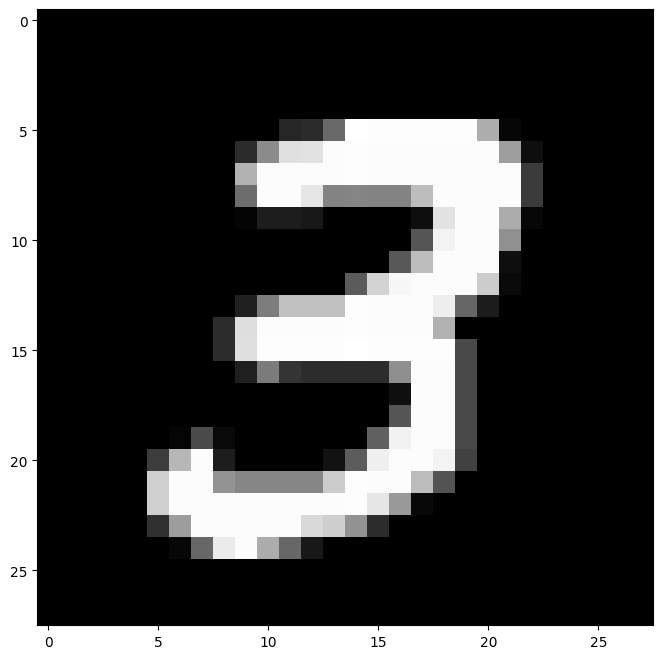

In [16]:
print(f'Label equals "{labels[picture_index]}"')

pic_data = np.reshape(data[picture_index], (28,28)).T  # ...reshaping and transpose of array needed
imgplot = plt.imshow(pic_data, cmap='gray')

# Assumtion: all data correctly labeled / no inconsistencies found (so far)

## ...split of data: training and test set (+histogram)

In [17]:
from sklearn.model_selection import train_test_split

# Split of 50:50 (following taks description, 75:25 default) and shuffle
seed = 42  # ...The answer / "seed" used for reproducibility
split = 0.5  # ...50:50 b/c 3000 pictures will be tested @final review (6000 available)
val_split = 0.1  # ...10% of training data for validation used

# First split: getting "training data" (incl validation data) & test data
training_data, test_data, training_labels, test_labels = \
    train_test_split(data, labels, test_size=split, random_state=seed)

# Second split: getting "used" training data and validation data
val_training_data, val_val_data, val_training_labels, val_val_labels = \
    train_test_split(training_data, training_labels, test_size=val_split, random_state=seed)

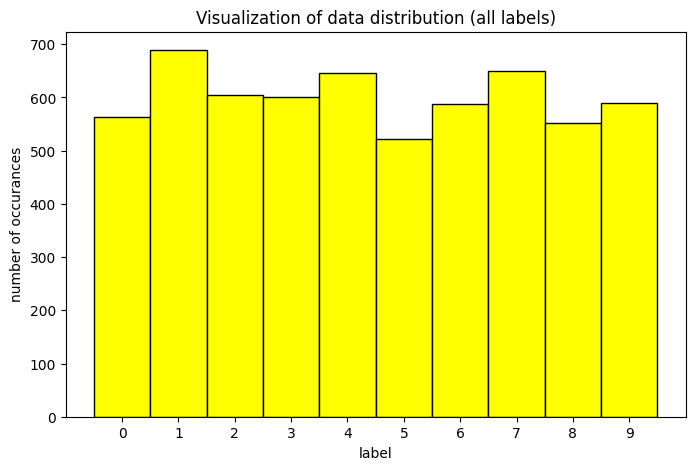

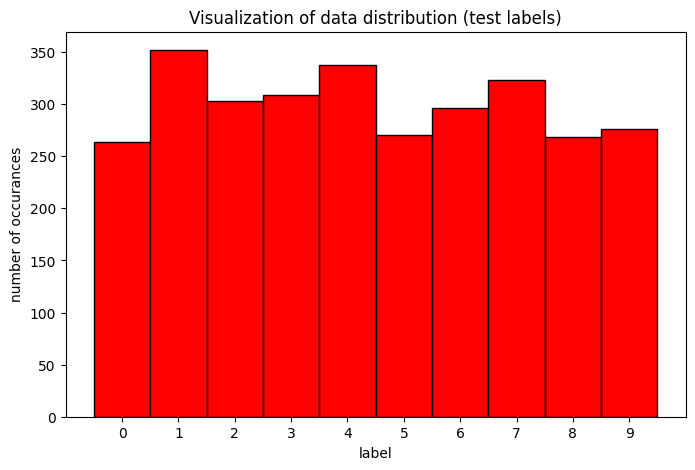

In [18]:
# Visualization of distribution (histogram) for "all labels"
fig, axis = plt.subplots(figsize =(8, 5))  # ...smaller plots
bins = np.arange(-0.5, 10, 1)
axis.hist(labels, bins, align='mid', color='yellow', edgecolor='black', linewidth=1)
plt.title('Visualization of data distribution (all labels)')
plt.xlabel('label')
plt.ylabel('number of occurances')
plt.xticks([x for x in range(10)])

# Distribution for the "test labels"
fig, axis = plt.subplots(figsize =(8, 5))
axis.hist(test_labels, bins, align='mid', color='red', edgecolor='black', linewidth=1)
plt.title('Visualization of data distribution (test labels)')
plt.xlabel('label')
plt.ylabel('number of occurances')
plt.xticks([x for x in range(10)])
plt.show()

# ...data splitted into "usable" parts for training and testing?
# (matching distribution for representative tree construction)

# Decision Tree (branching via parameters)

## ...via "sklearn" module (theory)

>...uses an optimized version of the **CART** algorithm (Classification and Regression Trees)

(https://scikit-learn.org/stable/modules/tree, 2022)

>...Various Decision Tree Algorithms (...C5.0 & CART)

(https://medium.datadriveninvestor.com/the-basics-of-decision-trees-e5837cc2aba7)

>The basic CART building algorithm is a **greedy** algorithm in that it chooses the locally best discriminatory feature at each stage in the process. This is suboptimal but a full search for a fully optimized set of question would be computationallly very expensive. Although there are pathological cases in most data sets this greediness is not a problem.

(https://www.cstr.ed.ac.uk/projects/speech_tools/manual-1.2.0/c16616.htm, 2022)

## ...import of additional modules

In [19]:
from scipy.stats import randint
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import model_selection as ms
from sklearn.model_selection import RandomizedSearchCV

## ...construct and train classifiers (decision trees via OOP)

In [20]:
class ClassifierModel:
    def __init__(self, training_data, training_labels, quality_func='gini', 
                 min_samples_leaf=1, prepruning=0.0, cross_v=False):  # Defautls

        self.__classifier = DecisionTreeClassifier(  # Constructor*
            criterion=quality_func,  # For optimization ('gini'|'entropy')
            # ...gini = computational simpler/faster, entropy more precise 
            
            splitter='best',  # =default / "random best" as alternative...
            # ...to choose the split at each node (best pixel VS random pixel)

            max_depth=None,  # ~"early stopping"... limiting tree depth
            
            min_samples_split=2,
            min_samples_leaf=min_samples_leaf,  
            # ...min number of samples to be at a "leaf node"

            min_weight_fraction_leaf=0.0,
            max_features=None,
            random_state=None,
            max_leaf_nodes=None,
            min_impurity_decrease=0.0,

            class_weight=None,  # ...to rebalance misshaped data distribution
            
            ccp_alpha=prepruning)

        self.__cross_v = cross_v
        # 2 variations / "ms.cross_val_score" trains and scores model in one...
        if cross_v:
          self.__classifier.fit(training_data, training_labels)
          self.scores = ms.cross_val_score(
              estimator=self.__classifier, X=training_data, y=training_labels, 
              cv=5, n_jobs=4).mean()
              # Mean used for "cv decision trees" b/c of multiple scores
              # "cross_val_score" not usable to train & predict, 
              # ...therefore .fit used additionally
        else:
        # ...or "classical" training of the model w/o "cross validation"
          self.__classifier.fit(training_data, training_labels)
          self.scores = self.__classifier.score(test_data, test_labels)
        
        print(type(self.scores))
    

    # Getter for private classifier object & attributes*
    def get_classifier(self):  
        return self.__classifier


    def get_cross_val(self):
        return self.__cross_v


    def get_score(self, data, labels):
        if self.__cross_v:
          pass  # No score for overfitting @cross validation so far
        else:
          return self.__classifier.score(data, labels)


In [21]:
# Parameters for random search (starting points for "cv_optimization")
param_dist = {'max_depth':  [None, 2, 4, 6, 8, 10], "min_samples_leaf": randint(2, 15), 
              "criterion": ["gini", "entropy"], 'splitter': ['best', 'random'], 
              "ccp_alpha": [0.001, 0.0001, 0.000012, 0.0005, 0.00008, 0.00009]}
              # "Magic numbers" explained: max_depth from empirical testing before...
              # ...sample_leaf: depending on data set size (content limit of leaf nodes)
              # ...testing out typical values for "ccp_alpha" (small values performed best)

tune_tree = DecisionTreeClassifier()
# Constructor directly out of module sklearn / for tree classifier (REP)

tree_cv = RandomizedSearchCV(tune_tree, param_dist, n_iter=100, cv = 5)
# ...cross validation to find optimized parameters for tree (local optimization!)

tree_cv.fit(training_data, training_labels)
# ...training of tree w/ training data & labels


print("best para: ", tree_cv.best_params_)
print("score: ", tree_cv.best_score_)

best para:  {'ccp_alpha': 9e-05, 'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 4, 'splitter': 'best'}
score:  0.7470000000000001


DecisionTreeClassifier (see https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier)

Minimal Cost-Complexity Pruning (see https://scikit-learn.org/stable/modules/tree.html#minimal-cost-complexity-pruning)

Parameter optimization (see https://stats.stackexchange.com/questions/579320/how-does-randomized-search-cv-algorithm-work)

In [22]:
# Creation of different "decition trees":
min_samples_leaf_v = 42  # Selected for differnt results
prepruning_v = 0.001  # "usable" value after several runs 

standard_decision_tree = ClassifierModel(training_data, training_labels)
# ...model created w/ standard parameters

standard_cv_dec_tree = ClassifierModel(
    training_data, training_labels, cross_v=True)
# ...cross validation used w/ standard parameters

prepruned_decision_tree = ClassifierModel(
    training_data, training_labels, prepruning=prepruning_v)
# ...prepruning w/ "ccp_alpha = 0.001" used

prepruned_cv_dec_tree = ClassifierModel(
    training_data, training_labels, cross_v=True, prepruning=prepruning_v)
# ...cross validation & prepruning w/ "ccp_alpha...

leaflimit_decision_tree = ClassifierModel(
    training_data, training_labels, min_samples_leaf = min_samples_leaf_v, 
    prepruning=prepruning_v)
# ...w/ prepruning and limit on minimum of needed samples for every "leaf node"

cv_leaflimit_tree = ClassifierModel(
    training_data, training_labels, cross_v=True, min_samples_leaf = min_samples_leaf_v, 
    prepruning=prepruning_v)
# ...cross validation & see above

entropy_decision_tree = ClassifierModel(
    training_data, training_labels, quality_func='entropy', prepruning=prepruning_v)
# ...w/ prepruning and "entropy" (instead of "gini") as quality function

cv_entropy_tree = ClassifierModel(
    training_data, training_labels, cross_v=True, quality_func='entropy', prepruning=prepruning_v)
# ...cross validation & see above

<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>


In [23]:
# Collection of different decision trees (same seed)
decision_trees = {'standard': standard_decision_tree,  'standard_cv': standard_cv_dec_tree,
                  'prepruned': prepruned_decision_tree,  'prepruned_cv': prepruned_cv_dec_tree, 
                  'leaflimit': leaflimit_decision_tree, 'leaflimit_cv': cv_leaflimit_tree,
                  'entropy': entropy_decision_tree, 'entropy_cv': cv_entropy_tree}

## ...accuracy of classifiers (error measurement via test data)

In [24]:
score_bm = 0  # "bm" ..."benchmark"
tree_bm = None
output_acc = ''

for key_name, decision_tree in decision_trees.items():
    test_score =  decision_tree.scores
    # ...uses trained model of "classifier" / returns the "accuracy" on given test data and labels

    str_var = f'{key_name} \t with R: \t {test_score:.2f}'
    output_acc += str_var + '\n'  # ...for comparison (3 blocks below)
    print(str_var)
    # ...R is the "ratio" of correctly predicted labels (1 == 100% correct)
    
    if test_score > score_bm:  # ...find best iteratively
        score_bm = test_score
        key_bm = key_name
        tree_bm = decision_trees[key_bm]
  
print(f'\nbest tree is "{key_bm}"')
# Best also depending on split (best found were "entropy" & "prepruned")

standard 	 with R: 	 0.74
standard_cv 	 with R: 	 0.74
prepruned 	 with R: 	 0.76
prepruned_cv 	 with R: 	 0.74
leaflimit 	 with R: 	 0.68
leaflimit_cv 	 with R: 	 0.65
entropy 	 with R: 	 0.74
entropy_cv 	 with R: 	 0.75

best tree is "prepruned"


**".score" and "accuracy_score" are the same** ("subset accuracy")

> ...score: comparing the predictions of the model against the real labels...

(https://www.kaggle.com/getting-started/27261, 2022)

## ...test for overfitting (test on training set)

In [25]:
# Overfitting measured (...on training data)
for key_name, decision_tree in decision_trees.items():
    training_score = decision_tree.get_score(training_data, training_labels) 
    # ...== get_classifier().score(training_data, training_labels)

    if training_score is not None:
      print(f'{key_name} \t with R: \t {training_score:.2f}')
    # ...training_score of 1 implies overfitting (all training data fitting perfectly == too precise)

standard 	 with R: 	 1.00
prepruned 	 with R: 	 0.91
leaflimit 	 with R: 	 0.72
entropy 	 with R: 	 0.98


In [26]:
# Direct comparision w/ accuracy ...on test data
for line in output_acc.split('\n'):
  if '_cv' in line:
    continue
  print(line)

standard 	 with R: 	 0.74
prepruned 	 with R: 	 0.76
leaflimit 	 with R: 	 0.68
entropy 	 with R: 	 0.74



...if "ratio" of training data (3 blocks above) is much higher than of test data (block above) we are clearly overfitted 

(or training/test data was not representative, not likely: distribution plotted/checked before)

## ...predict labels of test data (plotted example w/ best tree)

In [27]:
picture_index = 11  # NOT number... (REP)
# Example found w/ seed that shows classifier error

Label (predicted) as "3"


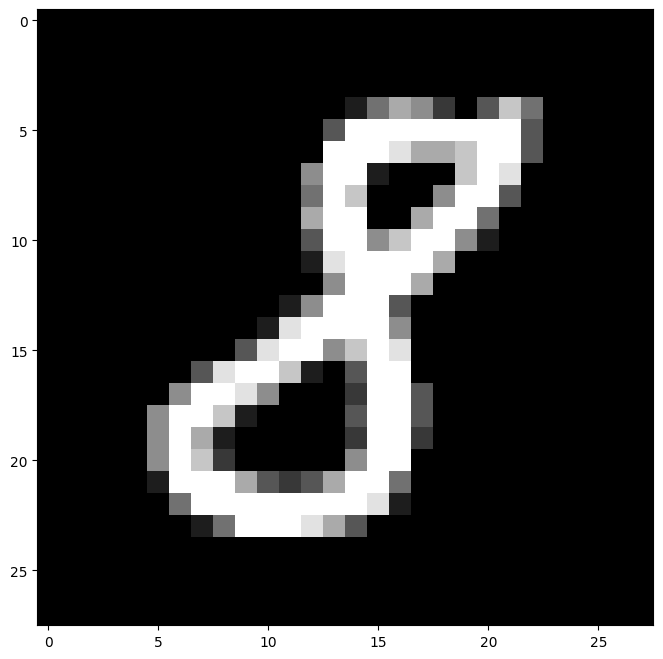

In [28]:
# Using best classifier so far (tree_bm)
predicted_labels = tree_bm.get_classifier().predict(test_data)  # ...as numpy.array()
print(f'Label (predicted) as "{predicted_labels[picture_index]}"')

pic_data = np.reshape(test_data[picture_index], (28,28)).T  # ...reshaping of array (REP)
imgplot = plt.imshow(pic_data, cmap='gray')

In [29]:
picture_index = 6
# Another example found w/ seed that shows classifier error

Label (predicted) as "4"


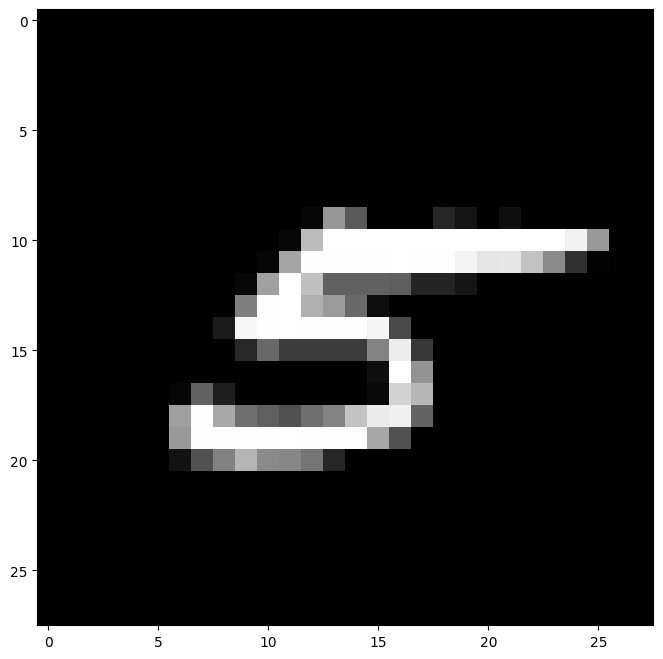

In [30]:
predicted_labels = tree_bm.get_classifier().predict(test_data)
print(f'Label (predicted) as "{predicted_labels[picture_index]}"')

pic_data = np.reshape(test_data[picture_index], (28,28)).T
imgplot = plt.imshow(pic_data, cmap='gray')

## ...confidence interval (95% choosen =standard)

In [31]:
from statsmodels.stats.proportion import proportion_confint 

0.7460797889563099 0.7765868777103567
0.7456625587793551 0.7764928329190076
0.7457516766295064 0.7762465784367233


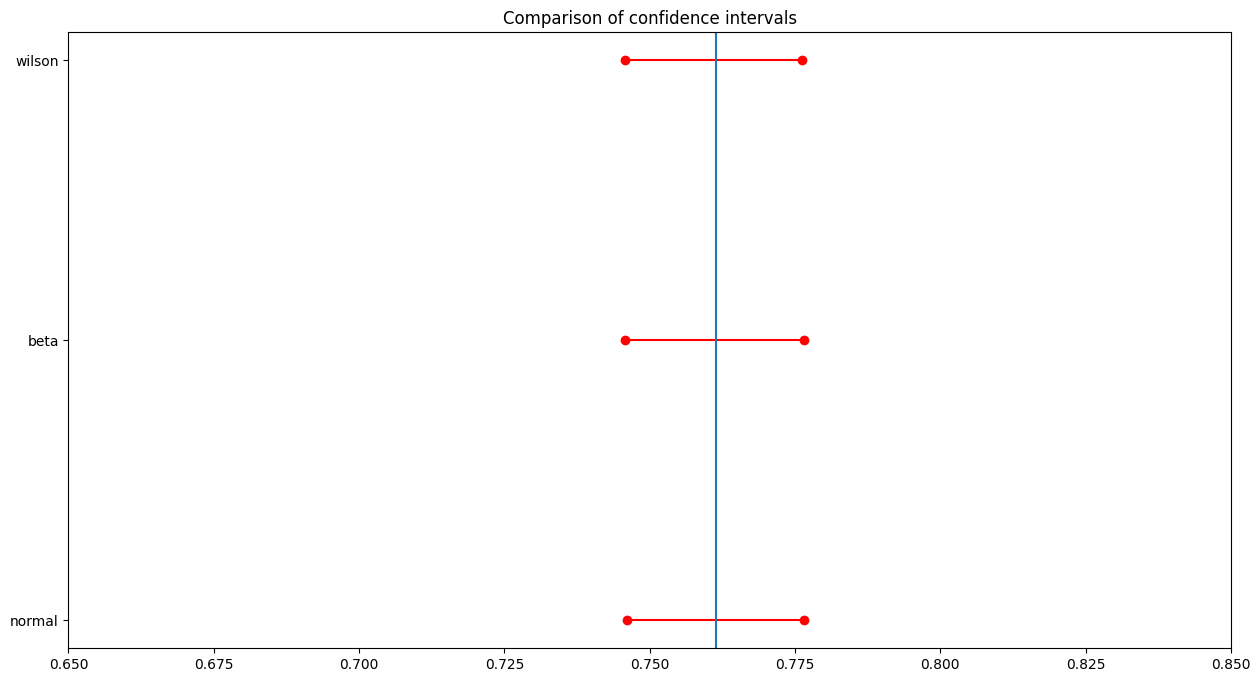

In [32]:
dc_ac_score = score_bm

x1, x2 = proportion_confint((dc_ac_score * len(test_labels)), len(test_labels), alpha=0.05)  
print(x1,x2)

x3,x4 = proportion_confint((dc_ac_score * len(test_labels)), len(test_labels), alpha=0.05, method='beta')
print(x3,x4)

x5,x6 = proportion_confint((dc_ac_score * len(test_labels)), len(test_labels), alpha=0.05, method='wilson')
print(x5,x6)

data_dict = {}
data_dict['category'] = ['normal','beta', 'wilson']
data_dict['lower'] = [x1,x3,x5]
data_dict['upper'] = [x2,x4,x6]
dataset = pd.DataFrame(data_dict)

for lower,upper,y in zip(dataset['lower'],dataset['upper'],range(len(dataset))):
  plt.plot((lower,upper),(y,y),'ro-')
  plt.xlim(0.65, 0.85)
  plt.yticks(range(len(dataset)),list(dataset['category']))

plt.axvline(x=dc_ac_score)
plt.title('Comparison of confidence intervals')
plt.show()

# Similar >narrow< confidence intervals also for beta & wilson distribution...

## ...visualize and plot (best) decision tree

In [33]:
text_baum = tree.export_text(tree_bm.get_classifier())
print(text_baum)  # CLI output

with open('decistion_tree.log', "w") as file_out:
    file_out.write(text_baum)  # .log output

|--- feature_245 <= 0.50
|   |--- feature_295 <= 0.50
|   |   |--- feature_378 <= 10.50
|   |   |   |--- feature_298 <= 16.00
|   |   |   |   |--- feature_425 <= 2.50
|   |   |   |   |   |--- feature_296 <= 149.00
|   |   |   |   |   |   |--- feature_405 <= 72.50
|   |   |   |   |   |   |   |--- feature_158 <= 21.00
|   |   |   |   |   |   |   |   |--- class: 7
|   |   |   |   |   |   |   |--- feature_158 >  21.00
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- feature_405 >  72.50
|   |   |   |   |   |   |   |--- feature_443 <= 160.00
|   |   |   |   |   |   |   |   |--- class: 9
|   |   |   |   |   |   |   |--- feature_443 >  160.00
|   |   |   |   |   |   |   |   |--- class: 7
|   |   |   |   |   |--- feature_296 >  149.00
|   |   |   |   |   |   |--- class: 9
|   |   |   |   |--- feature_425 >  2.50
|   |   |   |   |   |--- feature_491 <= 24.50
|   |   |   |   |   |   |--- feature_457 <= 5.50
|   |   |   |   |   |   |   |--- class: 5
|   |   |   |   |   |

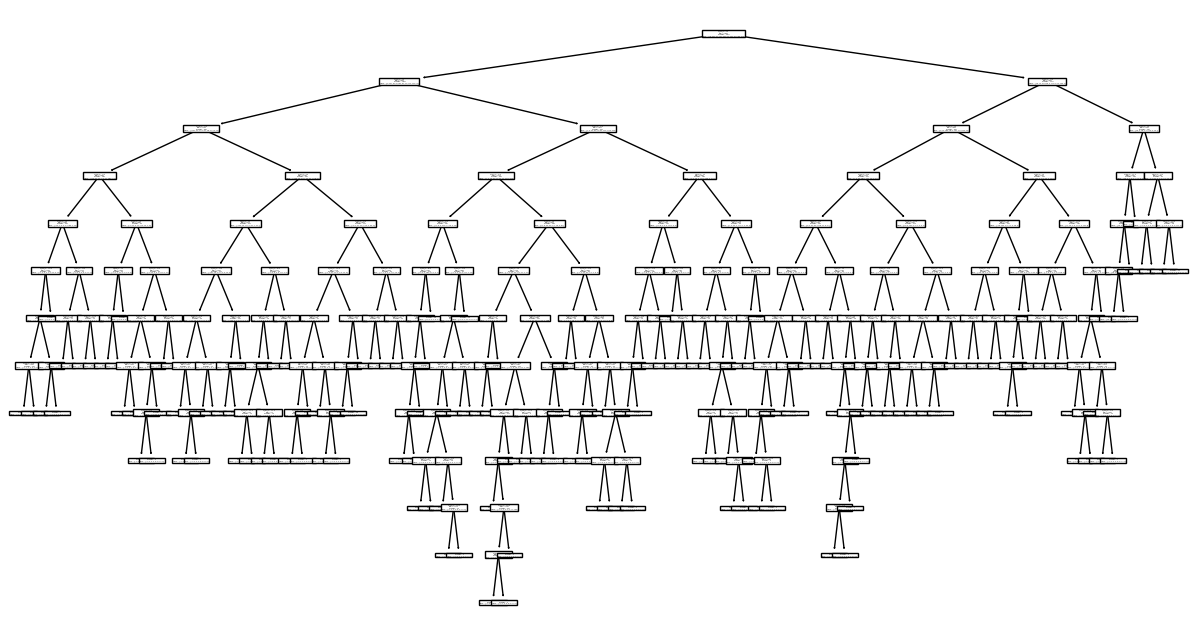

In [34]:
tree.plot_tree(tree_bm.get_classifier()) # ...plotting of decision tree
plt.show()  # Advantage of decision trees: "explainable" (..AI)

# Constructed tree w/ provided data & seed results in a relatively balanced tree (lower error propagation)

# Naive Bayes classifier (simple probabilistic classification)

## ...via "sklearn" module (theory)

>...Naive Bayes algorithms. These are supervised learning methods based on applying Bayes’ theorem with strong (naive) feature independence assumptions.

(https://scikit-learn.org/stable/modules/classes.html?highlight=naive+bayes#module-sklearn.naive_bayes, 2022)

Handwriten numbers **don't fullfill strong independence** in reality: neighbored pixels have often same color / connection via written line 

## ...import of additional modules

In [35]:
from sklearn.naive_bayes import GaussianNB  # Standard, but worse then others... (see below)
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

## ...construct classifiers (NB), train and predict

In [36]:
gnb = GaussianNB()  # Not optimized...
label_pred = gnb.fit(training_data, training_labels).predict(test_data)

# Multinomial Naive Bayes, tried adapted multinomial NB(ComplementNB) suited for imbalanced sets which auto weights but was way worse
mnb = MultinomialNB()
label_pred2 = mnb.fit(training_data, training_labels).predict(test_data)

# Bernoulli NB tends to outperform multinomial with more training data; roughly even on our 50:50 split
bnb = BernoulliNB()
label_pred3 = bnb.fit(training_data, training_labels).predict(test_data)

In [37]:
prediction = tree_bm.get_classifier().predict(test_data)  # bm... benchmark tree from above

In [38]:
# Output of scores ("accuracy_score")
print("Bayes(Gaussian): \t", (round(accuracy_score(test_labels,label_pred),3)), 
      "  \t No. mislabeled out of %d points: \t %d" % (
          test_data.shape[0], (test_labels != label_pred).sum()))

print("Bayes(Multinomial): \t",(round(accuracy_score(test_labels,label_pred2), 3)), 
      "  \t No. mislabeled out of %d points: \t %d" % (
          test_data.shape[0], (test_labels != label_pred2).sum()))

print("Bayes(Bernoulli): \t",(round(accuracy_score(test_labels,label_pred3), 3)), 
      "  \t No. mislabeled out of %d points: \t %d" % (
          test_data.shape[0], (test_labels != label_pred3).sum()))

print("DecTree_benchmark: \t",(round(accuracy_score(test_labels,prediction), 3)), 
      "  \t No. mislabeled out of %d points: \t %d" % (
          test_data.shape[0], (test_labels != prediction).sum()))

Bayes(Gaussian): 	 0.625   	 No. mislabeled out of 3000 points: 	 1124
Bayes(Multinomial): 	 0.828   	 No. mislabeled out of 3000 points: 	 516
Bayes(Bernoulli): 	 0.825   	 No. mislabeled out of 3000 points: 	 526
DecTree_benchmark: 	 0.761   	 No. mislabeled out of 3000 points: 	 716


In [39]:
# Baseline from untrained (randomly constructed) classifier
from sklearn.dummy import DummyClassifier

X = training_data
y = training_labels
dummy = DummyClassifier(strategy="prior")
dummy.fit(X, y)  # Random pick better than trained?

print("Baseline comparison", round(dummy.score(test_data, test_labels), 3))
# ...(hopefully) NOT better:

Baseline comparison 0.117


## ...predict labels of test data (plotted example from NB)

In [40]:
picture_index = 11  # NOT number... (REP)
# Better than decision tree benchmark (for provided data from "alldigits.csv")

Label (predicted) as "8"


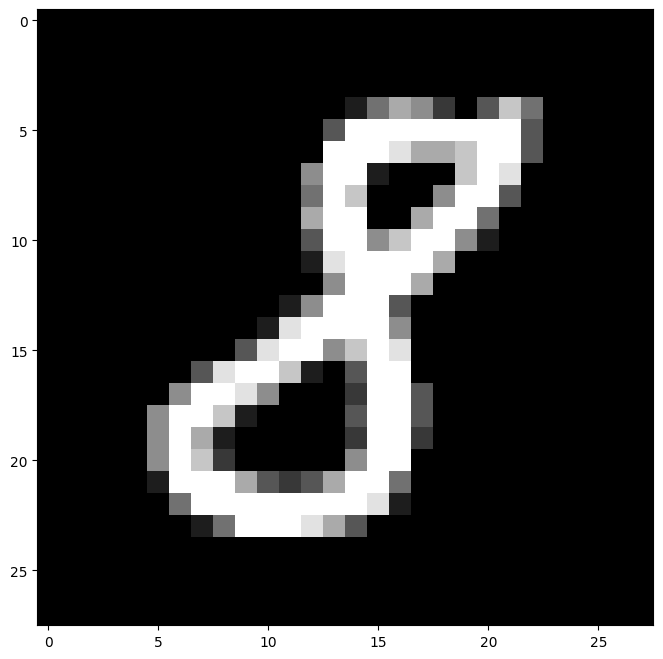

In [41]:
# Using one of the best nb so far: "bnb" (besides "mnb")
predicted_labels = bnb.predict(test_data)
print(f'Label (predicted) as "{predicted_labels[picture_index]}"')

pic_data = np.reshape(test_data[picture_index], (28,28)).T
imgplot = plt.imshow(pic_data, cmap='gray')

In [42]:
picture_index = 6
# >Same< labeling error as decision tree benchmark (for provided ...REP)

Label (predicted) as "4"


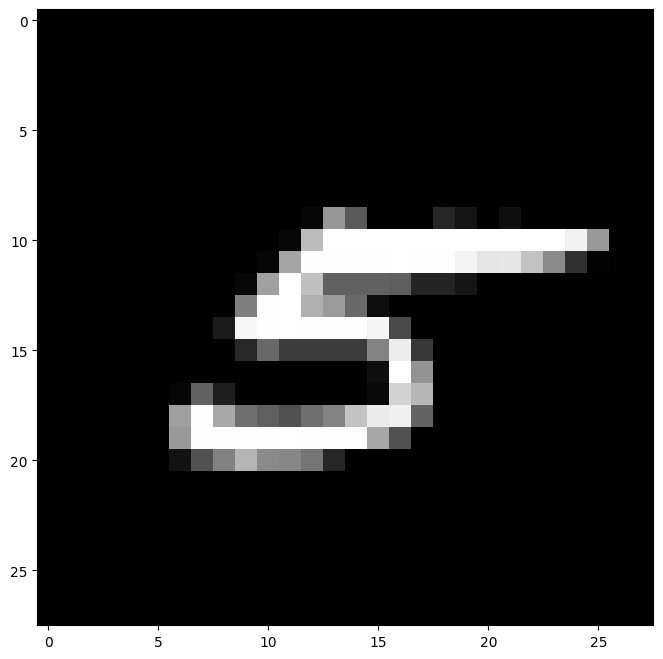

In [43]:
predicted_labels = bnb.predict(test_data)
print(f'Label (predicted) as "{predicted_labels[picture_index]}"')

pic_data = np.reshape(test_data[picture_index], (28,28)).T
imgplot = plt.imshow(pic_data, cmap='gray')

## ...confidence interval (95% again)

In [44]:
from statsmodels.stats.proportion import proportion_confint 

0.811059774950986 0.8382735583823473
0.8105784809742824 0.8381185877039998
0.8106469414997779 0.8378559927279103


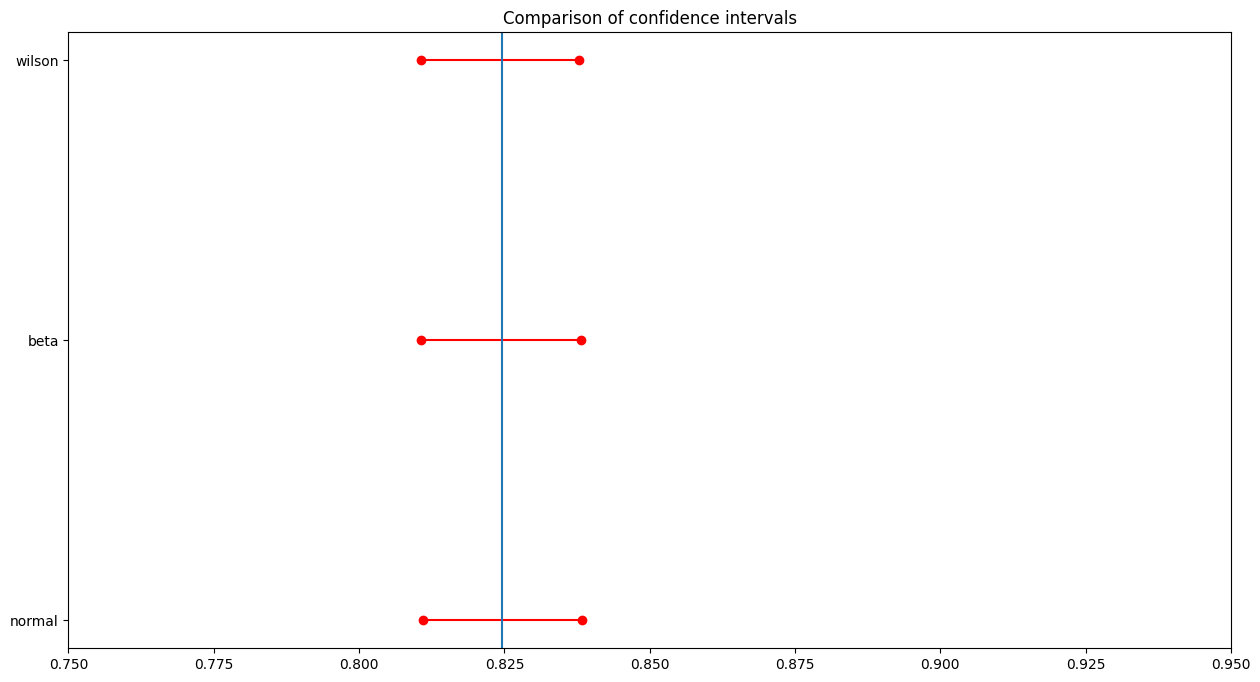

In [45]:
bnb_ac_score = accuracy_score(test_labels,label_pred3)

x1, x2 = proportion_confint((bnb_ac_score * len(test_labels)), len(test_labels), alpha=0.05)  
# ...default=normal : asymptotic normal approximation
print(x1,x2)

x3,x4 = proportion_confint((bnb_ac_score * len(test_labels)), len(test_labels), alpha=0.05, method='beta')
print(x3,x4)

x5,x6 = proportion_confint((bnb_ac_score * len(test_labels)), len(test_labels), alpha=0.05, method='wilson')
print(x5,x6)

data_dict = {}
data_dict['category'] = ['normal','beta', 'wilson']
data_dict['lower'] = [x1,x3,x5]
data_dict['upper'] = [x2,x4,x6]
dataset = pd.DataFrame(data_dict)

for lower,upper,y in zip(dataset['lower'],dataset['upper'],range(len(dataset))):
  plt.plot((lower,upper),(y,y),'ro-')
  plt.xlim(0.75, 0.95)
  plt.yticks(range(len(dataset)),list(dataset['category']))

plt.axvline(x=bnb_ac_score)
plt.title('Comparison of confidence intervals')
plt.show()

# Similar >narrow< confidence intervals also for beta & wilson distribution...

# Conclusion (comparison "decision tree" | "naive bayes")

## ...interpretation of results

Decision trees performed worse with the found parameters and provided data, even though the independence condition of the naive bayes classifier was not fulfilled given the concrete task/data. 

Changing the parameters of the naive bayes classifiers didn't lead to significant improvements, therefore no further parameter optimization was included.

Only for the decision trees an optimizaton was done, manually and via the "RandomizedSearchCV" method (see "cv_optimization").

Overall the change of paramaters yielded only small gains in performance for our dataset.

The accuracies for better performing classifiers were in the mid to high dot-seventies range for decision trees and in the low dot-eighties range for good NB classifiers (only few outliers after iterative testing). Narrow confidence intervals confirm the estimated accuracy results.

## ...summary statement

The task of classifying handwritten numbers is not ideal for "decision trees" or "naive bayes" classifiers. The dependency of neighbored pixels was not used in an appropriate way. Today "neural networks" are used for this OCR tasks.

Considering industrial applications where a reliable classification of such numbers will be needed (production papers, quality tests, etc) even the better performing naive bayes classifiers can not be recommended.